# Initial EDA - Multi-Class Prediction of Cirrhosis Outcomes

Goal: use a multi-class approach to predict the the outcomes of patients with cirrhosis.  

Evaluation: Submissions are evaluated using multi-class logarithmic loss. Each id in the test set has a single true class label, Status. For each id in the test set, you must submit a set of predicted possible outcomes (e.g. "Status_C", "Status_CL", and "Status_D").

Submission: The file should contain a header and have the following format:

        id,Status_C,Status_CL,Status_D
        7905,0.628084,0.034788,0.337128
        7906,0.628084,0.034788,0.337128
        7907,0.628084,0.034788,0.337128
        etc.

## 1. Intruction

#### Why do we do this?

> Liver cirrhosis or hepatic cirrhosis, and end-stage liver disease, is the impaired liver function caused by the formation of scar tissue known as fibrosis due to damage caused by liver disease. Damage to the liver leads to repair of liver tissue and subsequent formation of scar tissue. Over time, scar tissue can replace normal functioning tissue, leading to the impaired liver function of cirrhosis. (...) 

> Cirrhosis is most commonly caused by alcoholic liver disease, non-alcoholic steatohepatitis (NASH – the progressive form of non-alcoholic fatty liver disease), heroin abuse, chronic hepatitis B, and chronic hepatitis C. Heavy drinking over a number of years can cause alcoholic liver disease. Liver damage has also been attributed to heroin usage over an extended period of time as well.
[Source: Wikipedia]

#### Data provenance

During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial.

#### What we need to predict

- use a multi-class approach to predict the the outcomes of patients with liver cirrhosis

#### Evaluation

**Multi-class logarithmic loss** from each injury type and an any_injury prediction generated by the metric

$$\text{logloss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{M} y_ij log(p_ij) $$

where $N$ is the number of rows in the test set, $M$ is the number of outcomes (i.e. 3), $log$ is the natural logarithm, $y_ij$ is 1 if observation $i$ is in outcome $j$ and 0 otherwise, and $p_ij$ is the predicted probability that observation $i$ belongs to outcome $j$.

**The submitted probabilities for a given row are not required to sum to one** because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with.

For each id in the test set, you must submit a set of predicted possible outcomes (e.g. "Status_C", "Status_CL", and "Status_D").

#### 📚 **Libraries**


In [2]:
# essentials
import os
import pathlib

import pandas as pd
import numpy as np
from tqdm import tqdm

# visualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split
import xgboost as xgb 

## 2. Exploration

#### Data Dictionary

Dataset contains 17 clinical features and 1 target variable.

| Variable | Type | Description |
| --- | --- | --- |
| Status | Categorical/Target | Status of the patient - C (censored), CL (censored due to liver tx) or D (death) |
| N_Days | Integer | Number of days between registration and the earlier of death, transplant or study analysis time (July 1986) |
| Drug | Categorical | Drug used - D-penicillamine (D) or placebo (P) |
| Age | Integer | Age (in days) |
| Sex | Categorical | (M)ale or (F)emale |
| Ascites | Categorical | Presence of ascites - Y (yes) or N (no) |
| Hepatomegaly | Categorical | Presence of hepatomegaly - Y (yes) or N (no) |
| Spiders | Categorical | Presence of spiders - Y (yes) or N (no) |
| Edema | Categorical | Presence of edema - N (no edema and no diuretic therapy for edema), S (edema present without diuretics or edema resolved by diuretics), Y (edema despite diuretic therapy) |
| Bilirubin | Float | Serum bilirubin (mg/dl) |
| Cholesterol | Integer | Serum cholesterol (mg/dl) |
| Albumin | Float | Serum albumin (gm/dl) |
| Copper | Integer | Urinary copper (ug/day) |
| Alk_Phos | Integer | Alkaline phosphatase (U/liter) |
| SGOT | Float | (serum) glutamic oxaloacetic transaminase (U/ml) |
| Triglycerides | Integer | Triglycerides |
| Platelets | Integer | Platelets per cubic (ml/1000) |
| Prothrombin | Float | Prothrombin time (s) |
| Stage | Categorical | Histologic stage of disease - 1, 2, 3, 4 |

#### Target column - Status

Total number of training examples: 7905


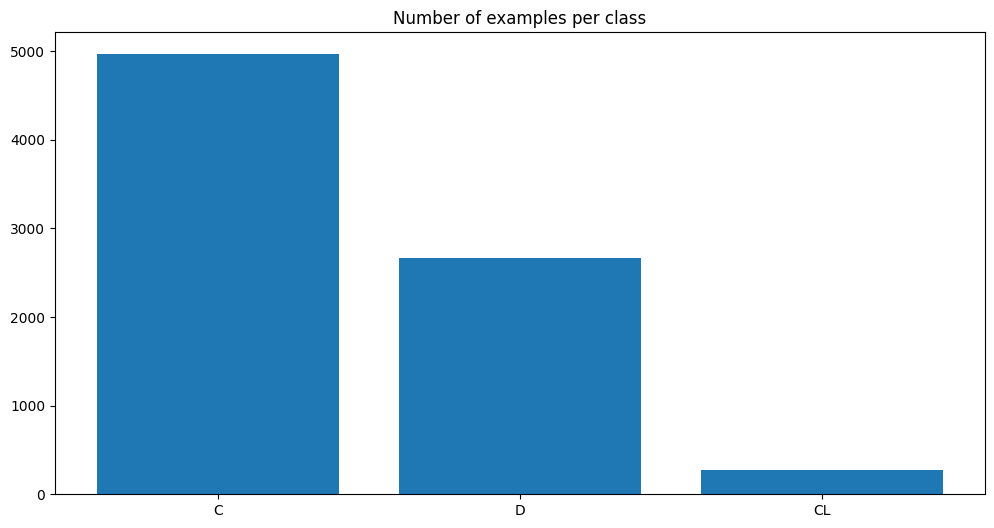

Number of examples in class C: 4965 (62.81%)
Number of examples in class D: 2665 (33.71%)
Number of examples in class CL: 275 (3.48%)


In [15]:
train_df = pd.read_csv("./data/train.csv")
target_column = "Status"

print(f"Total number of training examples: {len(train_df)}")

# plot number of different examples belonging to each target_column values, by value and by percentage

fig, ax = plt.subplots(1, 1, figsize=(12, 6))


total_examples = len(train_df)
number_of_examples = train_df[target_column].value_counts().values
labels = train_df[target_column].value_counts().index
percentages = []

for number in number_of_examples:
    percentages.append(number/total_examples)

ax.title.set_text("Number of examples per class")
ax.bar(labels, number_of_examples)

plt.show()

for label, value, percentage in zip(labels, number_of_examples, percentages):
    print(f"Number of examples in class {label}: {value} ({percentage*100:.2f}%)")

#### Categorical features

| Variable | Type | Description |
| --- | --- | --- |
| Drug | Categorical | Drug used - D-penicillamine (D) or placebo (P) |
| Sex | Categorical | (M)ale or (F)emale |
| Ascites | Categorical | Presence of ascites - Y (yes) or N (no) |
| Hepatomegaly | Categorical | Presence of hepatomegaly - Y (yes) or N (no) |
| Spiders | Categorical | Presence of spiders - Y (yes) or N (no) |
| Edema | Categorical | Presence of edema - N (no edema and no diuretic therapy for edema), S (edema present without diuretics or edema resolved by diuretics), Y (edema despite diuretic therapy) |
| Stage | Categorical | Histologic stage of disease - 1, 2, 3, 4 |

<Axes: xlabel='Drug', ylabel='count'>

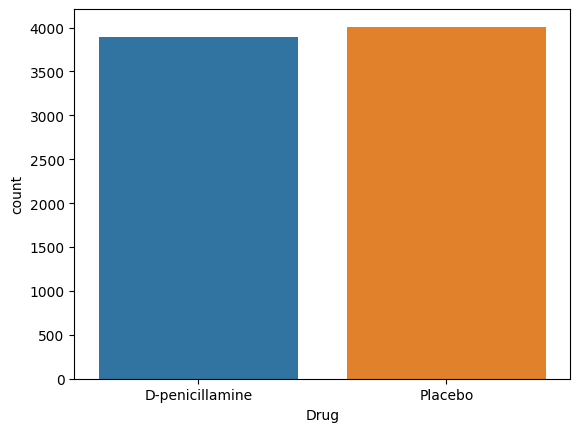

In [17]:
categorical_columns = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

sns.countplot(data=train_df, x="Drug")

<Axes: xlabel='Sex', ylabel='count'>

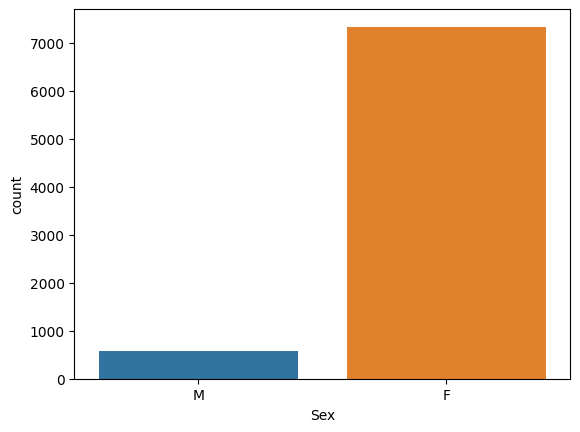

In [18]:
sns.countplot(data=train_df, x="Sex")

<Axes: xlabel='Ascites', ylabel='count'>

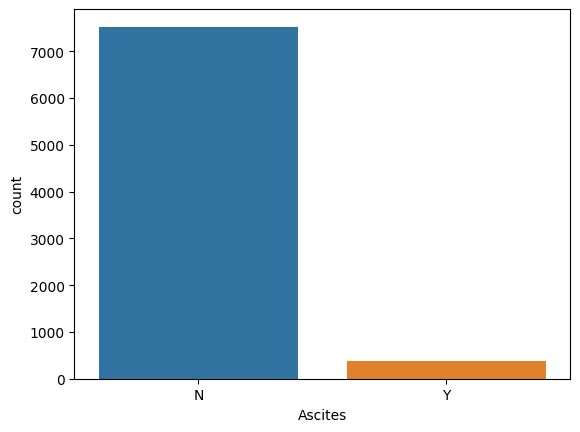

In [19]:
sns.countplot(data=train_df, x="Ascites")

<Axes: xlabel='Hepatomegaly', ylabel='count'>

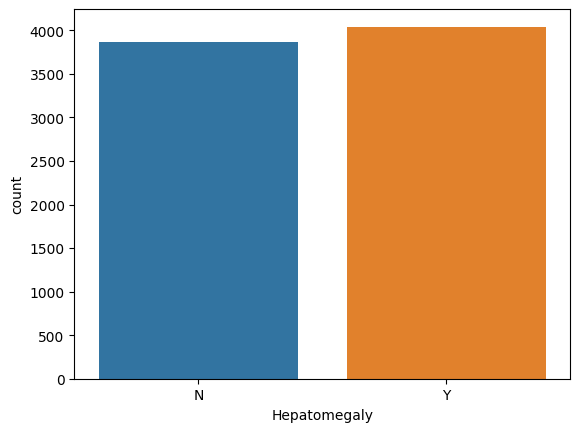

In [20]:
sns.countplot(data=train_df, x="Hepatomegaly")

<Axes: xlabel='Spiders', ylabel='count'>

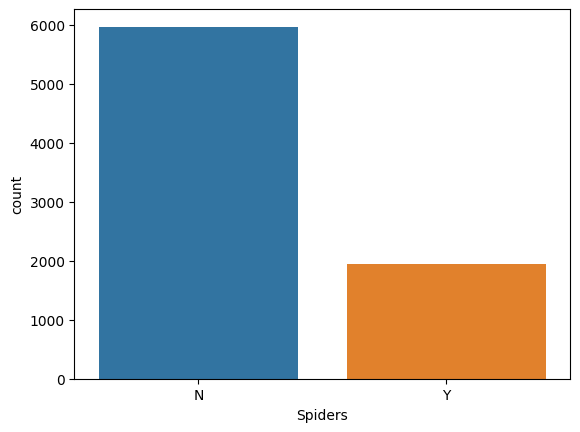

In [21]:
sns.countplot(data=train_df, x="Spiders")

<Axes: xlabel='Edema', ylabel='count'>

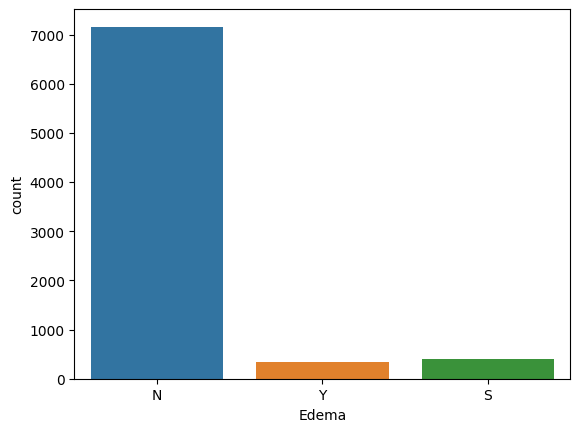

In [22]:
sns.countplot(data=train_df, x="Edema")

<Axes: xlabel='Stage', ylabel='count'>

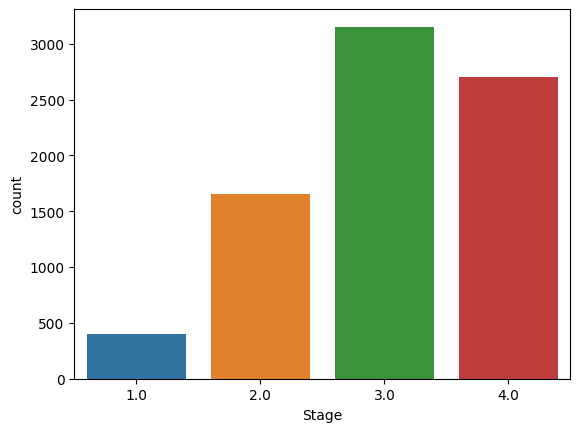

In [23]:
sns.countplot(data=train_df, x="Stage")

#### Numerical features